In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("data/SHEL_data.csv")

In [3]:
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,36.250000,36.360001,35.494999,36.029999,31.140999,6794599
1,2021-01-05,37.189999,39.014999,37.115002,38.509998,33.284489,8518589
2,2021-01-06,39.910000,40.680000,39.564999,40.290001,34.822952,9180332
3,2021-01-07,40.000000,40.625000,39.744999,40.340000,34.866161,4829303
4,2021-01-08,40.360001,40.419998,39.770000,40.240002,34.779736,5546750
...,...,...,...,...,...,...,...
972,2024-11-13,65.010002,65.800003,64.459999,65.480003,64.795242,5945070
973,2024-11-14,65.879997,66.120003,65.650002,65.790001,65.101997,5438087
974,2024-11-15,65.489998,65.769997,65.269997,65.470001,65.470001,4349310
975,2024-11-18,66.110001,66.570000,65.915001,66.320000,66.320000,3329354


In [4]:
import math, os, torch, numpy as np, pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [101]:
SEQ_LEN = 60
BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
HIDDEN_SIZE = 64
N_LAYERS = 1
N_FUTURE = 1
TARGET_DIM = 6

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [103]:
torch.manual_seed(42)
np.random.seed(42)

In [104]:
dataset["Date"] = pd.to_datetime(dataset["Date"])

In [105]:
df = dataset

In [106]:
df = df.sort_values("Date").reset_index(drop = True)

In [107]:
feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

In [108]:
full_cols = ["Date"] + feature_cols

In [109]:
df = df[["Date","Open","High","Low","Close","Adj Close","Volume"]]

In [110]:
values = df[feature_cols].values.astype(np.float32)

In [111]:
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values).astype(np.float32)

In [112]:
class SeqDataset(Dataset):
    def __init__(self, array, seq_len):
        self.X, self.y = [], []
        T, D = array.shape
        for i in range(T - seq_len):
            self.X.append(array[i:i+seq_len])
            self.y.append(array[i+seq_len])
        self.X = np.stack(self.X)
        self.y = np.stack(self.y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

In [113]:
N = len(values)

In [114]:
split = int(N * 0.9)

In [115]:
train_ds = SeqDataset(values_scaled[:split], SEQ_LEN)

In [116]:
val_ds = SeqDataset(values_scaled[split-SEQ_LEN:], SEQ_LEN)

In [117]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [118]:
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [119]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True
        )
        self.head = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h, _ = self.rnn(x)
        last = h[:, -1, :]
        out = self.head(last)
        return out

In [121]:
D = values_scaled.shape[1]

In [122]:
model = SimpleRNN(input_size=D, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, output_size=D, n_future = N_FUTURE, target_dim = TARGET_DIM).to(device)

In [123]:
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [124]:
loss_fn = nn.MSELoss()


In [125]:
def evaluate():
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total += loss_fn(pred, yb).item() * xb.size(0)
            n += xb.size(0)
    return total / max(1, n)

In [127]:
best_val = math.inf

In [128]:
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    val_loss = evaluate()
    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:3d} | train_loss {loss.item():.6f} | val_loss {val_loss:.6f}")

/scratch/users/nishankr/micromamba/envs/229proj/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 6])) that is different to the input size (torch.Size([64, 1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/scratch/users/nishankr/micromamba/envs/229proj/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([34, 6])) that is different to the input size (torch.Size([34, 1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch   1 | train_loss 1.042565 | val_loss 1.521592
epoch   5 | train_loss 0.825870 | val_loss 1.690277
epoch  10 | train_loss 0.692065 | val_loss 1.696398
epoch  15 | train_loss 0.948687 | val_loss 1.705446
epoch  20 | train_loss 0.888138 | val_loss 1.673482
epoch  25 | train_loss 0.758531 | val_loss 1.777341
epoch  30 | train_loss 0.884278 | val_loss 1.714980


In [129]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [130]:
model.to(device)

AttentionRNN(
  (rnn): GRU(6, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (head): Linear(in_features=64, out_features=6, bias=True)
)

In [131]:
model.eval()

AttentionRNN(
  (rnn): GRU(6, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (head): Linear(in_features=64, out_features=6, bias=True)
)

In [132]:
with torch.no_grad():
    # last window from the full series
    last_window = values_scaled[-SEQ_LEN:].copy()  # [T, D]
    window_t = torch.from_numpy(last_window).unsqueeze(0).to(device)  # [1, T, D]

    preds_scaled = []
    cur_window = window_t.clone()

    for _ in range(N_FUTURE):
        next_step, attn_weights = model(cur_window)          # [1, D] scaled
        preds_scaled.append(next_step.squeeze(0).cpu().numpy())
        # append and drop oldest for next iteration
        next_step_expanded = next_step.unsqueeze(1)          # [1, 1, D]
        cur_window = torch.cat([cur_window[:, 1:, :], next_step_expanded], dim=1)

    preds_scaled = np.stack(preds_scaled, axis=0)  # [N_FUTURE, D]
    preds = scaler.inverse_transform(preds_scaled) # back to original units

RuntimeError: Tensors must have same number of dimensions: got 3 and 4

: 

In [57]:
last_date = df["Date"].iloc[-1]

In [58]:
future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=N_FUTURE)

In [59]:
pred_df = pd.DataFrame(preds, columns=feature_cols)

In [60]:
pred_df.insert(0, "Date", future_dates)

In [61]:
print(pred_df.head(N_FUTURE))

        Date       Open       High        Low      Close  Adj Close     Volume
0 2024-11-20  68.590889  69.673485  67.555649  69.094566  65.362106  4524802.5
1 2024-11-21  68.499352  69.584221  67.475655  69.008446  65.270607  4527532.5
2 2024-11-22  68.425331  69.513306  67.412010  68.940430  65.197433  4529698.0
3 2024-11-25  68.347305  69.438889  67.345306  68.869812  65.120682  4531902.5
4 2024-11-26  68.295341  69.387192  67.298752  68.820030  65.068192  4533523.0
5 2024-11-27  68.272720  69.364296  67.278191  68.798157  65.045082  4534239.0
6 2024-11-28  68.286652  69.372169  67.284996  68.804817  65.055748  4534287.0
7 2024-11-29  68.267685  69.355789  67.270409  68.790390  65.037781  4534598.5
8 2024-12-02  68.291710  69.376869  67.289467  68.810539  65.060043  4534061.5
9 2024-12-03  68.304832  69.389580  67.301704  68.824242  65.073341  4533593.0


In [66]:
def one_step_tail_predictions(n_tail=60):
    """Return last n_tail actual vs. one-step predictions for inspection."""
    xs, ys = [], []
    arr = values_scaled[-(n_tail+SEQ_LEN):]  # just a tail
    for i in range(arr.shape[0] - SEQ_LEN):
        xs.append(arr[i:i+SEQ_LEN])
        ys.append(arr[i+SEQ_LEN])
    xs = torch.from_numpy(np.stack(xs)).to(device)
    ys = np.stack(ys)
    with torch.no_grad():
        pred_scaled, attn_weights = model(xs)
        pred_scaled = pred_scaled.cpu().numpy()
    pred = scaler.inverse_transform(pred_scaled)
    truth = scaler.inverse_transform(ys)
    dates_aligned = df["Date"].iloc[-len(truth):].reset_index(drop=True)
    out = pd.DataFrame(np.concatenate([truth, pred], axis=1),
                       columns=[f"true_{c}" for c in feature_cols] + [f"pred_{c}" for c in feature_cols])
    out.insert(0, "Date", dates_aligned)
    return out

In [67]:
tail_compare = one_step_tail_predictions(120)
tail_pred_df = tail_compare.tail(60)

In [68]:
tail_pred_df.columns

Index(['Date', 'true_Open', 'true_High', 'true_Low', 'true_Close',
       'true_Adj Close', 'true_Volume', 'pred_Open', 'pred_High', 'pred_Low',
       'pred_Close', 'pred_Adj Close', 'pred_Volume'],
      dtype='object')

In [69]:
true_adj_close = tail_pred_df['true_Adj Close'].values
pred_adj_close = tail_pred_df['pred_Adj Close'].values

In [70]:
import matplotlib.pyplot as plt

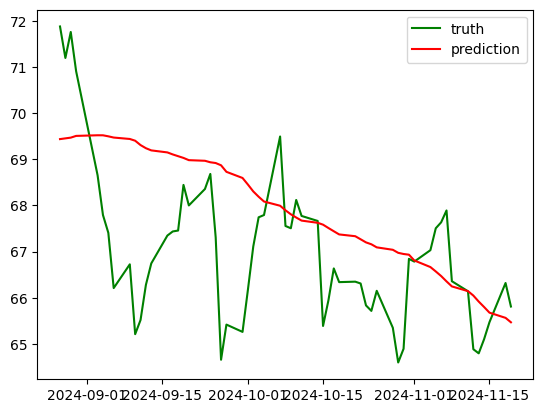

In [71]:
plt.plot(tail_pred_df['Date'].values, true_adj_close, c = 'green', label = 'truth')
plt.plot(tail_pred_df['Date'].values, pred_adj_close, c = 'red', label = 'prediction')
plt.legend()
plt.show()

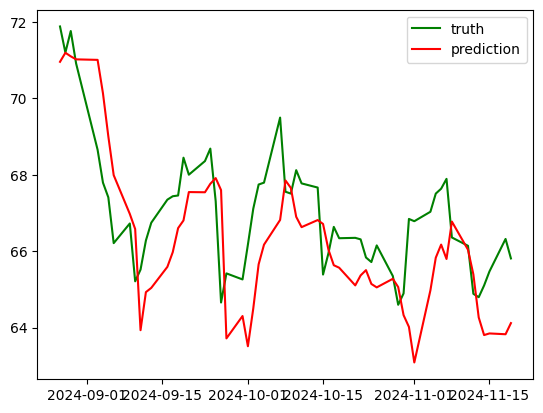

In [96]:
plt.plot(tail_pred_df['Date'].values, true_adj_close, c = 'green', label = 'truth')
plt.plot(tail_pred_df['Date'].values, pred_adj_close, c = 'red', label = 'prediction')
plt.legend()

plt.show()

In [97]:
true_all = tail_pred_df[[f"true_{c}" for c in feature_cols]].values   # shape [T, 6]
pred_all = tail_pred_df[[f"pred_{c}" for c in feature_cols]].values   # shape [T, 6]

# MSE per feature (one MSE for each of the 6 outputs)
mse_per_feature = ((pred_all - true_all) ** 2).mean(axis=0)

# Overall MSE across all features and timesteps
mse_overall = ((pred_all - true_all) ** 2).mean()

print("MSE per feature:")
for name, mse in zip(feature_cols, mse_per_feature):
    print(f"{name}: {mse:.6f}")

print("\nOverall MSE across all 6 outputs:", mse_overall)

MSE per feature:
Open: 1.496605
High: 1.594677
Low: 1.758507
Close: 1.667863
Adj Close: 2.324016
Volume: 3777854177280.000000

Overall MSE across all 6 outputs: 629642360000.0


In [98]:
# Extract true/pred arrays for all 6 features
true_all = tail_pred_df[[f"true_{c}" for c in feature_cols]].values   # shape [T, 6]
pred_all = tail_pred_df[[f"pred_{c}" for c in feature_cols]].values   # shape [T, 6]

# RMSE per feature
rmse_per_feature = np.sqrt(((pred_all - true_all) ** 2).mean(axis=0))

# Overall RMSE across all 6 features and all timesteps
rmse_overall = np.sqrt(((pred_all - true_all) ** 2).mean())

print("RMSE per feature:")
for name, rmse in zip(feature_cols, rmse_per_feature):
    print(f"{name}: {rmse:.6f}")

print("\nOverall RMSE across all 6 outputs:", rmse_overall)

RMSE per feature:
Open: 1.223358
High: 1.262805
Low: 1.326087
Close: 1.291458
Adj Close: 1.524472
Volume: 1943670.250000

Overall RMSE across all 6 outputs: 793500.06
